> **MSC DEEP LEARNING ASSIGNMENT**

In [ ]:
# Importing essential libraries for numerical operations and data handling.
import numpy as np  # Provides support for arrays, matrices, and a large collection of mathematical functions to operate on these.
import pandas as pd  # Offers data structures and operations for manipulating numerical tables and time series.

# Importing libraries for working with the file system.
import os  # Provides a portable way of using operating system dependent functionality like reading or writing to files.

# Importing PyTorch libraries for building and training neural networks.
import torch  # The main PyTorch library, providing tensor objects for storing and operating on data.
import torch.nn as nn  # Contains modules and utilities for building neural networks.
import torch.nn.functional as F  # Provides functions like activation functions and convolution operations you can apply to tensors.
import torch.optim as optim  # Includes optimization algorithms like SGD and Adam for adjusting model parameters.

# Importing a library for creating plots and visualizations.
import matplotlib.pyplot as plt  # Used for plotting graphs and visualizing data in various forms.

# Importing utilities for working with PyTorch datasets and dataloaders.
from torch.utils.data import Dataset, DataLoader  # Dataset helps with organizing and preprocessing data; DataLoader allows easy batching and loading of the data.
from torch.nn.utils.rnn import pad_sequence  # Useful for padding sequences to the same length, especially in tasks involving sequential data like text or time series.


In [ ]:
# Mapping each amino acid to a unique integer for numerical processing.
# This is essential for converting protein sequences, which are represented by letters, into a format that can be easily
# handled by machine learning models. Each letter representing an amino acid is assigned a unique number.
amino_acid_mapping = {
    'A': 0,  # Alanine
    'R': 1,  # Arginine
    'N': 2,  # Asparagine
    'D': 3,  # Aspartic Acid
    'C': 4,  # Cysteine
    'Q': 5,  # Glutamine
    'E': 6,  # Glutamic Acid
    'G': 7,  # Glycine
    'H': 8,  # Histidine
    'I': 9,  # Isoleucine
    'L': 10, # Leucine
    'K': 11, # Lysine
    'M': 12, # Methionine
    'F': 13, # Phenylalanine
    'P': 14, # Proline
    'S': 15, # Serine
    'T': 16, # Threonine
    'W': 17, # Tryptophan
    'Y': 18, # Tyrosine
    'V': 19, # Valine
    '-': 20  # Gap or missing amino acid
}

# Mapping the secondary structure labels to integers.
# Secondary structures like helices (H), sheets (E), and coils (C) are represented by letters in datasets.
# This mapping converts them to numbers to facilitate the model's understanding and predictions.
structure_mapping = {
    'H': 0,  # Helix
    'E': 1,  # Beta sheet
    'C': 2   # Coil
}


In [ ]:

class ProteinDataset(Dataset):
    # Initializes the dataset object with file paths and optional maximum sequence length.
    def __init__(self, seqs_file, pssms_path, labels_file, most_measure=None):
        self.sequences = pd.read_csv(seqs_file)  # Loads the sequences from a CSV file.
        self.label_dt = pd.read_csv(labels_file)  # Loads the labels (secondary structure) from another CSV file.
        self.pssms_path = pssms_path  # Directory where PSSM files are stored.
        self.most_measure = most_measure  # Optional parameter to specify maximum sequence length for padding.

    # Returns the total number of sequences in the dataset.
    def __len__(self):
        return len(self.sequences)

    # Retrieves a single item from the dataset, processing it for model input.
    def __getitem__(self, idx):
        protein_id = self.sequences.iloc[idx]['PDB_ID']  # Extracts the protein ID for the given index.
        sequence = self.sequences.iloc[idx]['SEQUENCE']  # Extracts the sequence string for the protein.
        label_str = self.label_dt[self.label_dt['PDB_ID'] == protein_id]['SEC_STRUCT'].iloc[0]  # Finds the corresponding label string for the protein.

        # Constructs the path to the PSSM file and loads it, excluding specific columns.
        pssm_path = os.path.join(self.pssms_path, f"{protein_id}_train.csv")
        pssm = pd.read_csv(pssm_path).drop(['RES_NUM', 'AMINO_ACID'], axis=1).values
        pssm_modified = torch.tensor(pssm, dtype=torch.float32)  # Converts the PSSM data to a PyTorch tensor.
        
        # Converts the sequence and label strings to encoded tensors.
        seq_for_encode = self.sequence_modified(sequence)
        lab_for_encode = self.labels_modified(label_str)
        
        # Optionally pads the sequence, PSSM, and label tensors to a fixed length.
        if self.most_measure:
            seq_for_encode = self.tensor_postn(seq_for_encode, self.most_measure)
            pssm_modified = self.tensor_postn(pssm_modified, self.most_measure, pad_dim=0)
            lab_for_encode = self.tensor_postn(lab_for_encode, self.most_measure)

        return {'sequence': seq_for_encode, 'pssm': pssm_modified, 'labels': lab_for_encode}
    
    # Encodes a sequence string to a tensor using the amino acid mapping.
    def sequence_modified(self, sequence):
        encoded = [amino_acid_mapping.get(aa, 0) for aa in sequence]
        return torch.tensor(encoded, dtype=torch.long)
    
    # Encodes a label string to a tensor using the structure mapping.
    def labels_modified(self, label_str):
        labels = [structure_mapping.get(label, 2) for label in label_str]
        return torch.tensor(labels, dtype=torch.long)
    
    # Pads a tensor to a fixed length, used for both sequences and PSSM matrices.
    def tensor_postn(self, tensor, length, pad_dim=1, pad_value=0):
        if pad_dim == 0:
            # Pads PSSM matrices horizontally.
            post_modified = torch.zeros((length, tensor.shape[1]))
            post_modified[:tensor.shape[0], :] = tensor
        else:
            # Pads sequences and labels to the specified length.
            post_modified = torch.zeros(length, dtype=tensor.dtype) + pad_value
            post_modified[:len(tensor)] = tensor
        return post_modified


In [ ]:

# Define paths to the dataset files. These paths point to where the training sequences, 
# Position-Specific Scoring Matrices (PSSMs), and labels (secondary structures) are stored.
sequences_path = '/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv'  # Path to the sequences file.
pssms_path = '/kaggle/input/deep-learning-for-msc-202324/train'  # Directory containing PSSM files for each sequence.
labels_path = '/kaggle/input/deep-learning-for-msc-202324/labels_train.csv'  # Path to the labels (secondary structures) file.

# Initialize the dataset by providing the file paths to sequences, PSSMs, and labels.
# The `most_measure` parameter can be used to specify the maximum length for padding sequences and PSSMs.
# This is useful for standardizing the input size for neural network training.
dataset = ProteinDataset(seqs_file=sequences_path, pssms_path=pssms_path, labels_file=labels_path, most_measure=2000)

# Create a DataLoader for the dataset. DataLoaders are PyTorch utilities that allow for easy
# batching, shuffling, and parallel loading of data. Here, we define a batch size of 32 and
# enable shuffling to ensure the data is presented in a different order during each epoch,
# which can help improve model generalization.
p_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
class FCNProteinSecondaryStructure(nn.Module):
    # Initialize the fully convolutional network designed for predicting protein secondary structures.
    def __init__(self, num_classes=3):
        super(FCNProteinSecondaryStructure, self).__init__()
        
        # Embedding layer that converts amino acid indices to vectors of size 20.
        # This is important for capturing the semantic relationships between different amino acids.
        self.embedding = nn.Embedding(num_embeddings=21, embedding_dim=20)
        
        # Convolutional layers for processing sequence data.
        # These layers help in extracting spatial patterns from the sequence embeddings.
        self.line_layer1 = nn.Conv1d(in_channels=20, out_channels=64, kernel_size=3, padding=1)
        self.line_layer2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        
        # Convolutional layers for processing PSSM (Position-Specific Scoring Matrix) data.
        # PSSMs provide information about the conservation of amino acids at specific positions in an alignment.
        self.pssm_layer1 = nn.Conv1d(in_channels=20, out_channels=64, kernel_size=3, padding=1)
        self.pssm_layer2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        
        # Merging the pathways from sequence and PSSM processing to make final predictions.
        # This combines the features extracted from both the sequence and PSSM data.
        self.merge_layer1 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=1)
        self.merge_layer2 = nn.Conv1d(in_channels=128, out_channels=num_classes, kernel_size=1)

    # Defines the forward pass through the network.
    def forward(self, sequence, pssm):
        # Embed and permute sequence data for convolutional processing.
        seq = self.embedding(sequence).permute(0, 2, 1)
        seq = F.relu(self.line_layer1(seq))  # Apply convolution followed by ReLU activation.
        seq = F.relu(self.line_layer2(seq))
        
        # Process PSSM data similarly, applying convolutions and ReLU activations.
        pssm = pssm.permute(0, 2, 1)
        pssm = F.relu(self.pssm_layer1(pssm))
        pssm = F.relu(self.pssm_layer2(pssm))
        
        # Merge the processed sequence and PSSM features.
        merged = torch.cat((seq, pssm), dim=1)  # Concatenate the features along the channel dimension.
        merged = F.relu(self.merge_layer1(merged))  # Apply another convolution and activation to the merged features.
        output = self.merge_layer2(merged)  # Final convolution to predict the class scores for each position in the sequence.
        
        return output.permute(0, 2, 1)  # Permute the output back for consistency with target labels' shape.


In [ ]:
# Instantiate the model:
# Creates an instance of the FCNProteinSecondaryStructure class.
# This step initializes the neural network architecture defined earlier, preparing it for training and prediction.
model = FCNProteinSecondaryStructure()

# Define the loss function:
# Sets up the Cross Entropy Loss as the criterion for training. Cross Entropy Loss is commonly used
# for classification tasks, making it suitable for predicting protein secondary structures which can
# be viewed as a classification problem at each position of the sequence.
loss_function = nn.CrossEntropyLoss()

# Set up the optimizer:
# Initializes the Adam optimizer for updating the model's weights. Adam is chosen for its effectiveness
# in handling sparse gradients and adaptively adjusting learning rates, which can lead to better training outcomes.
# The learning rate is set to 0.001, a commonly used default value that can be adjusted based on training performance.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare the validation dataset:
# Here, the ProteinDataset class is used again to prepare the validation dataset. It's assumed you have a similar setup
# where sequences, PSSMs, and labels for the validation set are stored in the same format as the training set. 
# Providing the paths to these files and specifying 'most_measure' ensures that the sequences and PSSMs are
# padded or truncated to a consistent length, essential for batch processing.
val_dataset = ProteinDataset(seqs_file=sequences_path, pssms_path=pssms_path, labels_file=labels_path, most_measure=2000)

# Initialize the DataLoader for the validation dataset:
# The DataLoader utility is used to create batches from the validation dataset, facilitating more efficient
# loading and processing. Here, the batch size is set to 32, and shuffling is disabled for validation data
# since the order of evaluation does not impact performance metrics but maintaining a consistent order can
# be useful for comparing model outputs to actual values.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Preparing lists to keep track of the training and validation losses for each epoch.
# This helps in monitoring the model's performance over time.
train_losses = []
val_losses = []

# Set the total number of training cycles the model will go through.
num_epochs = 10

# Begin training over the specified number of epochs.
for epoch in range(num_epochs):
    # Switch the model to training mode. This enables layers like dropout and batch normalization
    # to behave differently during training compared to prediction time.
    model.train()
    # Initialize a variable to accumulate the loss over each batch within this epoch for training data.
    train_loss = 0
    
    # Iterate over each batch of data in the DataLoader.
    for batch in p_dataloader:
        # Unpack the current batch of data.
        sequences, pssms, labels = batch['sequence'], batch['pssm'], batch['labels']
        
        # Reset gradients to zero before starting backpropagation.
        optimizer.zero_grad()
        
        # Forward pass: Compute the predicted outputs by passing input data to the model.
        outputs = model(sequences, pssms)
        # Calculate the loss between the model's predictions and the actual labels.
        loss = loss_function(outputs.reshape(-1, 3), labels.reshape(-1))
        # Backward pass: Compute the gradient of the loss with respect to model parameters.
        loss.backward()
        # Update the model's parameters based on the gradients.
        optimizer.step()
        
        # Accumulate the loss over all batches to find the total loss for this epoch.
        train_loss += loss.item() * sequences.size(0)

    # Calculate the average training loss for this epoch.
    avg_train_loss = train_loss / len(p_dataloader.dataset)
    # Store the average training loss for this epoch to the list.
    train_losses.append(avg_train_loss)

    # Switch the model to evaluation mode. This makes layers like dropout and batch normalization
    # behave differently, suitable for when the model is being evaluated.
    model.eval()
    # Initialize a variable to accumulate the loss over each batch within this epoch for validation data.
    val_loss = 0
    # Temporarily disable gradient calculation for efficiency and to prevent modification of weights.
    with torch.no_grad():
        for batch in val_loader:
            # Unpack the current batch of validation data.
            sequences, pssms, labels = batch['sequence'], batch['pssm'], batch['labels']
            
            # Compute the model's output for the validation data.
            outputs = model(sequences, pssms)
            # Calculate the loss for the validation data.
            loss = loss_function(outputs.reshape(-1, 3), labels.reshape(-1))
            
            # Accumulate the validation loss over all batches to find the total loss for this epoch.
            val_loss += loss.item() * sequences.size(0)

    # Calculate the average validation loss for this epoch.
    avg_val_loss = val_loss / len(val_loader.dataset)
    # Store the average validation loss for this epoch to the list.
    val_losses.append(avg_val_loss)
    
    # Print the training and validation loss statistics after each epoch.
    print(f'Epoch {epoch+1}/{num_epochs}\tTraining Loss: {avg_train_loss:.6f}\tValidation Loss: {avg_val_loss:.6f}')


* Epoch 1/10	Training Loss: 0.125841	Validation Loss: 0.076947 
* Epoch 2/10	Training Loss: 0.074771	Validation Loss: 0.075354
* Epoch 3/10	Training Loss: 0.071343	Validation Loss: 0.069779
* Epoch 4/10	Training Loss: 0.069378	Validation Loss: 0.068398
* Epoch 5/10	Training Loss: 0.068250	Validation Loss: 0.067632
* Epoch 6/10	Training Loss: 0.067534	Validation Loss: 0.067298
* Epoch 7/10	Training Loss: 0.066510	Validation Loss: 0.066236
* Epoch 8/10	Training Loss: 0.065706	Validation Loss: 0.065130
* Epoch 9/10	Training Loss: 0.065176	Validation Loss: 0.064338
* Epoch 10/10	Training Loss: 0.064648	Validation Loss: 0.064625

In [ ]:
# Setting up the figure for plotting. This creates a plot with a specified size.
plt.figure(figsize=(10, 5))

# Plotting the training loss. The 'label' argument names the dataset for legend.
plt.plot(train_losses, label='Training Loss')

# Plotting the validation loss. Similarly, naming it for the legend.
plt.plot(val_losses, label='Validation Loss')

# Adding a title to the plot. This gives an overview of what the plot represents.
plt.title('Training and Validation Loss')

# Labeling the x-axis as 'Epochs'. This represents the number of complete passes through the dataset.
plt.xlabel('Epochs')

# Labeling the y-axis as 'Loss'. This represents the magnitude of error or deviation from the true values.
plt.ylabel('Loss')

# Displaying a legend to distinguish between training and validation loss lines.
plt.legend()

# Displaying the plot. This visual representation helps in understanding how the model's performance changes over time.
plt.show()


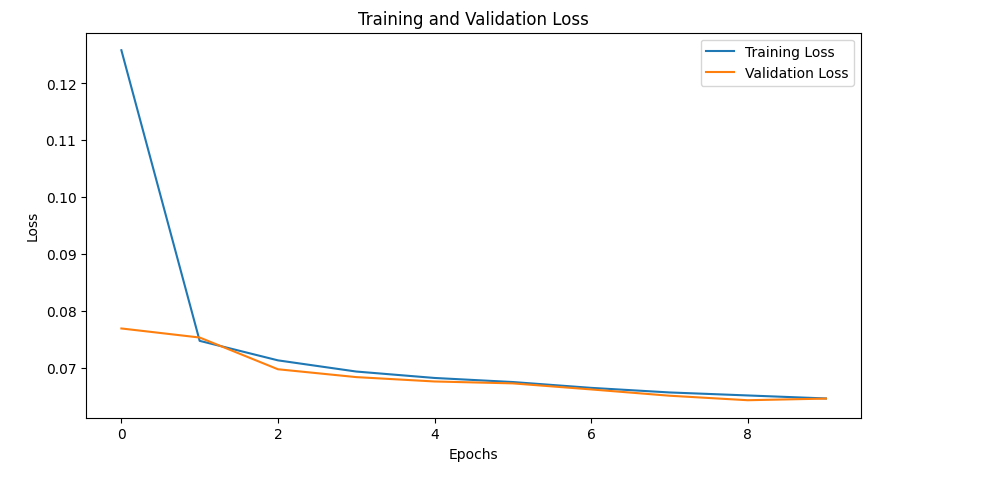
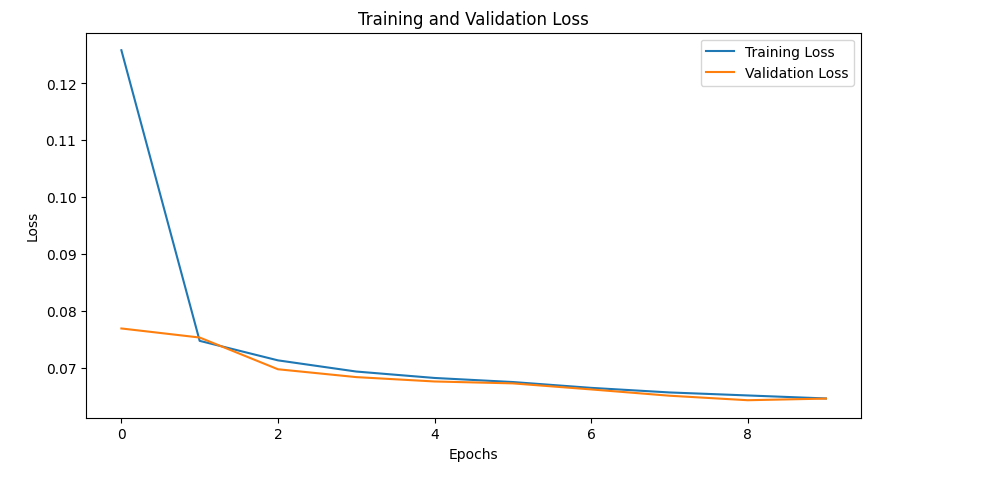

In [ ]:
class ProteinTestDataset(Dataset):
    """
    A custom dataset class for loading and processing protein test data, including sequences and PSSMs.
    """
    def __init__(self, seqs_file, pssms_path, most_measure=None):
        # Load protein sequences from a specified CSV file.
        self.sequences = pd.read_csv(seqs_file)
        # Directory where PSSM files for each protein are stored.
        self.pssms_path = pssms_path
        # Optional parameter to specify a uniform length for padding or truncating sequences and PSSMs.
        self.most_measure = most_measure

    def __len__(self):
        # Returns the total number of protein sequences in the dataset.
        return len(self.sequences)

    def __getitem__(self, idx):
        # Retrieves a single protein data point by its index.
        protein_id = self.sequences.iloc[idx]['PDB_ID']  # Unique identifier for the protein.
        sequence = self.sequences.iloc[idx]['SEQUENCE']  # Amino acid sequence of the protein.
        
        seq_length = len(sequence)  # Length of the protein sequence.
        
        # Constructs the path to the corresponding PSSM file and loads it.
        pssm_path = os.path.join(self.pssms_path, f"{protein_id}_test.csv")
        pssm = pd.read_csv(pssm_path).drop(['RES_NUM', 'AMINO_ACID'], axis=1).values
        pssm_modified = torch.tensor(pssm, dtype=torch.float32)  # Converts PSSM data into a tensor.
        
        # Converts the amino acid sequence into a numeric tensor using predefined encoding.
        seq_for_encode = self.sequence_modified(sequence)
        
        # Optionally pads the encoded sequence and PSSM to a specified uniform length.
        if self.most_measure:
            seq_for_encode = self.tensor_postn(seq_for_encode, self.most_measure)
            pssm_modified = self.tensor_postn(pssm_modified, self.most_measure, pad_dim=0)

        # Returns a dictionary containing the processed data points: protein ID, encoded sequence, modified PSSM, and sequence length.
        return {'protein_id': protein_id, 'sequence': seq_for_encode, 'pssm': pssm_modified, 'seq_length': seq_length}
    
    def sequence_modified(self, sequence):
        """
        Encodes a protein sequence into numeric format based on a predefined mapping of amino acids to integers.
        """
        # Dictionary mapping each amino acid to a unique integer for numerical processing.
        amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
        aa_to_idx = {aa: idx + 1 for idx, aa in enumerate(amino_acids)}
        # Converts each amino acid in the sequence to its corresponding integer value.
        encoded = [aa_to_idx.get(aa, 0) for aa in sequence]
        return torch.tensor(encoded, dtype=torch.long)
    
    def tensor_postn(self, tensor, length, pad_dim=1, pad_value=0):
        """
        Pads a tensor to a specified length, accommodating both sequence and PSSM data.
        """
        if pad_dim == 0:
            # Pads PSSM data to ensure uniform size, crucial for batch processing in neural networks.
            post_modified = torch.zeros((length, tensor.shape[1]))
            post_modified[:tensor.shape[0], :] = tensor
        else:
            # Pads encoded sequences to a uniform length, ensuring consistency across the dataset.
            post_modified = torch.zeros(length, dtype=tensor.dtype) + pad_value
            post_modified[:len(tensor)] = tensor
        return post_modified


In [ ]:
# Define the path to the test sequences CSV file.
# This file contains the protein sequences that we want to evaluate the model on.
seqs_test_csv_path = '/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv'

# Define the directory path where the Position-Specific Scoring Matrix (PSSM) files for the test sequences are stored.
# PSSMs provide important evolutionary information which can be useful for predicting protein structures.
pssm_test_dir_path = '/kaggle/input/deep-learning-for-msc-202324/test'

# Initialize the ProteinTestDataset with the paths to the test sequences and PSSMs.
# The `most_measure` parameter is used to standardize the length of sequences and PSSMs, 
# ensuring that they are of a uniform size for processing by the model.
test_dataset = ProteinTestDataset(seqs_file=seqs_test_csv_path, pssms_path=pssm_test_dir_path, most_measure=2000)

# Create a DataLoader for the test dataset.
# The DataLoader simplifies the process of loading data, allowing for efficient, batch-wise iteration during testing.
# Here, we use a batch size of 1 since we might want to process and evaluate each test sequence individually without batching.
# `shuffle=False` is specified to maintain the order of the dataset, which can be important for matching predictions to their corresponding sequences.
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:

# Load the ground truth from 'sample.csv'
sample_df = pd.read_csv('/kaggle/input/deep-learning-for-msc-202324/sample.csv')

# Set up a list to store predictions and the corresponding PDB IDs
predictions = []
protein_ids = []
actual_length = []

# Generate predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch in test_dataloader:
        sequences, pssms = batch['sequence'], batch['pssm']
        seq_length = batch['seq_length']
        actual_length.append(seq_length)
        protein_id = batch['protein_id'][0]  # Assuming that the batch also returns the PDB ID
        logits = model(sequences, pssms)
        preds = torch.argmax(logits, dim=2).squeeze(0)  # Remove batch dimension and get class indices
        predictions.append(preds.numpy().tolist())  # Convert to list and store
        protein_ids.append(protein_id)

In [ ]:

label_map = {0: 'H', 1: 'E', 2: 'C'}

submission_data = []

for protein_id, protein_predictions, actual_length in zip(protein_ids, predictions, actual_length):
    for residue_index in range(actual_length):  # Only iterate up to the actual length of the sequence
        residue_id = f"{protein_id}_{residue_index + 1}"  # Residue numbering starts at 1
        pred = protein_predictions[residue_index]  # Get prediction for current residue
        structure_label = label_map.get(pred, 'C')  # Default to 'C' if pred is out of label_map
        submission_data.append((residue_id, structure_label))

submission_df = pd.DataFrame(submission_data, columns=['ID', 'STRUCTURE'])
submission_df.to_csv('submission.csv', index=False)

In [ ]:
# Prepare DataFrame for predictions with corresponding PDB IDs
pred_structures = []
for protein_id, pred in zip(protein_ids, predictions):
    for i, p in enumerate(pred):
        pred_structures.append((f"{protein_id}_{i+1}", p))  # Residue numbers are assumed to be 1-indexed

pred_df = pd.DataFrame(pred_structures, columns=['ID', 'PRED_STRUCTURE'])

# Join the predicted and actual structures based on the 'ID' column
comparison_df = sample_df.merge(pred_df, on='ID')

# Convert numeric predictions to their corresponding structure labels
comparison_df['PRED_STRUCTURE'] = comparison_df['PRED_STRUCTURE'].map({0: 'H', 1: 'E', 2: 'C'})

# Calculate the number of correct predictions
correct_predictions = (comparison_df['STRUCTURE'] == comparison_df['PRED_STRUCTURE']).sum()
total_predictions = comparison_df.shape[0]

# Calculate and print accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy Percentage: {accuracy:.4f}")

Accuracy: 0.4097


In [ ]:
# import os

# # Specify the file path
# file_path = "/kaggle/working/submission.csv"

# # Check if the file exists
# if os.path.exists(file_path):
#     # Remove the file
#     os.remove(file_path)
#     print("File removed successfully.")
# else:
#     print("File does not exist.")